In [212]:
%matplotlib inline
# Dependencies and Setup
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider
import seaborn as sns; sns.set()
import ppscore as pps
import seaborn as seabornInstance



In [213]:
import warnings
warnings.filterwarnings('ignore')

Read all files as indicated in subsequent cells containing data for labels and NLP formulated features of our project.

In [214]:
L_cap = pd.read_csv("./data/stock_spy.csv")
L_cap = L_cap.loc[L_cap['date']>'2016-01-01']
L_cap = L_cap.loc[:, ["date", "change"]]
L_cap.head(1)

,date,change
4068,2016-01-04,0.002644


In [215]:
M_cap = pd.read_csv("./data/stock_mdy.csv")
M_cap = M_cap.loc[M_cap['date']>'2016-01-01']
M_cap = M_cap.loc[:, ["date", "change"]]
M_cap.head(1)

,date,change
4068,2016-01-04,0.003601


In [216]:
S_cap = pd.read_csv("./data/stock_ijr.csv")
S_cap = S_cap.loc[S_cap['date']>'2016-01-01']
S_cap = S_cap.loc[:, ["date", "change"]]
S_cap.head(1)

,date,change
3924,2016-01-04,-0.006651


In [217]:
powell_econ = pd.read_csv("./data/powell_daydf_count.csv")
powell_econ.head(1)

,Date,Count
0,2021-02-10,11


In [218]:
powell_sentbyday = pd.read_csv("./data/powell_sentbydaydf_count.csv")
powell_sentbyday.head(1)

,Date,Sent_Count
0,2021-03-18,10


In [219]:
powell_sentbydaypos = pd.read_csv("./data/powell_sentbydayposdf_count.csv")
powell_sentbydaypos.head(1)

,Date,Pos_Count
0,2021-03-18,18


In [220]:
powell_sentbydayneg = pd.read_csv("./data/powell_sentbydaynegdf_count.csv")
powell_sentbydayneg.head(1)

,Date,Neg_Count
0,2021-03-18,8


Join data frames and create classification labels.

In [221]:
powell_mkt = L_cap.merge(powell_sentbydayneg, how='inner', left_on="date" ,right_on="Date")
powell_mkt = powell_mkt.merge(powell_sentbydaypos, how='inner' ,on="Date")
powell_mkt =  powell_mkt.merge(powell_sentbyday, how='inner' ,on="Date")
powell_mkt =  powell_mkt.merge(powell_econ, how='inner' ,on="Date")
powell_mkt['pos_neg'] = np.where (powell_mkt['change'] > 0,1,0)
powell_mkt['pos'] = np.where (powell_mkt['change'] > 0.002,1,0)
powell_mkt['neg'] = np.where (powell_mkt['change'] < -0.002,1,0)
powell_mkt['flat'] = np.where ((powell_mkt['change'] <= 0.002) & (powell_mkt['change'] >= -0.002) ,1,0)

powell_mkt.head()

,date,change,Date,Neg_Count,Pos_Count,Sent_Count,Count,pos_neg,pos,neg,flat
0,2016-02-26,-0.007529,2016-02-26,20,15,-5,3,0,0,1,0
1,2016-05-26,-0.000477,2016-05-26,59,61,2,20,0,0,0,1
2,2016-06-21,0.000672,2016-06-21,15,5,-10,8,1,0,0,1
3,2016-06-28,0.008537,2016-06-28,67,72,5,40,1,1,0,0
4,2016-09-29,-0.007948,2016-09-29,57,51,-6,4,0,0,1,0


Add % changes of fundamental factors as features.  Since they are monthly released data, the values of subsequent daily rows after each releasing date would be equal to their prior row until they reach the new releasing date.

In [222]:
powell_rgdp = pd.read_csv("./Data/RGDP.csv")
powell_rgdp.head()
#powell_rgdp['Date']=pd.to_datetime(powell_rgdp['Date'])
powell_mkt['date'] = pd.to_datetime(powell_mkt['date'])

In [223]:
powell_mkt['growthgap']=np.nan
for x in range(len(powell_rgdp.index)-1):
   powell_mkt.loc[((powell_mkt['date']>= powell_rgdp.loc[x][0]) & (powell_mkt['date']< powell_rgdp.loc[x+1][0])),['growthgap']]=powell_rgdp.loc[x][3]
powell_mkt.head(1)

,date,change,Date,Neg_Count,Pos_Count,Sent_Count,Count,pos_neg,pos,neg,flat,growthgap
0,2016-02-26,-0.007529,2016-02-26,20,15,-5,3,0,0,1,0,-0.4


In [224]:
powell_empsit = pd.read_csv("./Data/empsit.csv")
powell_empsit.head()
powell_mkt['date'] = pd.to_datetime(powell_mkt['date'])

In [225]:
powell_mkt['job_change']=np.nan
for x in range(len(powell_empsit.index)-1):
   powell_mkt.loc[((powell_mkt['date']>= powell_empsit.loc[x][0]) & (powell_mkt['date']< powell_empsit.loc[x+1][0])),['job_change']]=powell_empsit.loc[x][1]
#    print(wsb_mkt.loc[(wsb_mkt['date']>= wsb_empsit.loc[x][0]) & (wsb_mkt['date']< wsb_empsit.loc[x+1][0])]['job_change'])
powell_mkt.head(1)

,date,change,Date,Neg_Count,Pos_Count,Sent_Count,Count,pos_neg,pos,neg,flat,growthgap,job_change
0,2016-02-26,-0.007529,2016-02-26,20,15,-5,3,0,0,1,0,-0.4,108.0


<Figure size 432x288 with 0 Axes>

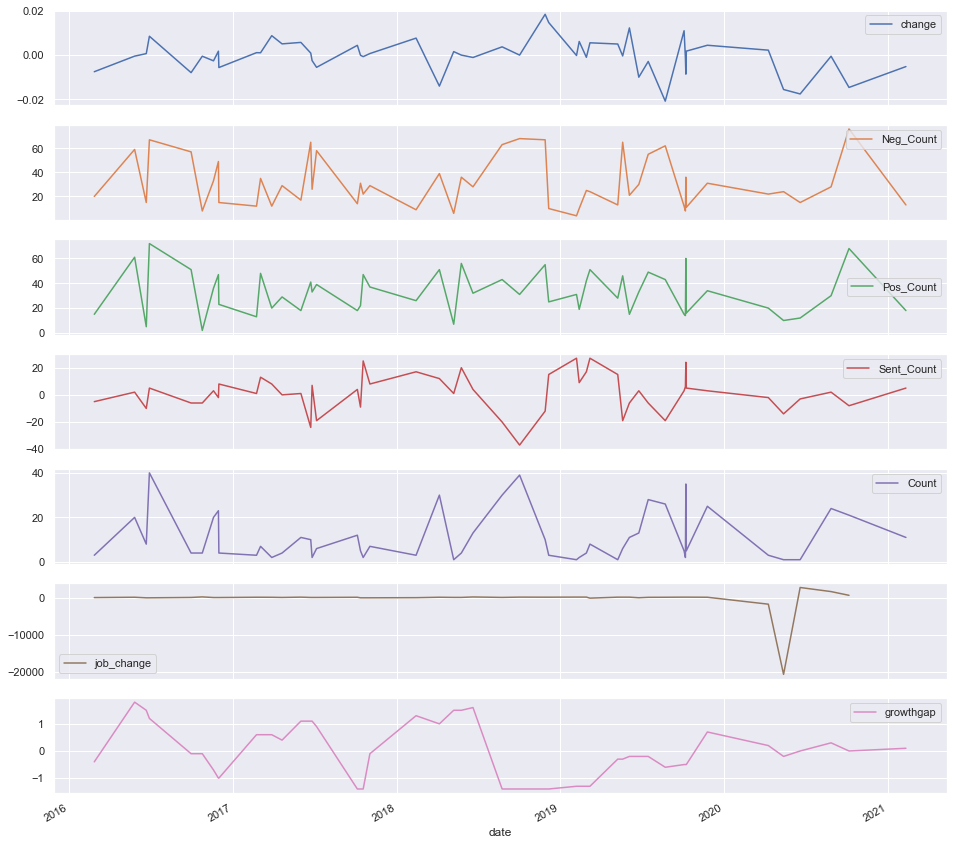

In [226]:
powell_mkt_hm1 = powell_mkt.loc[:, [
"date",
"change",
"Neg_Count",
"Pos_Count",
"Sent_Count",
"Count",
"job_change",
"growthgap"]]
powell_mkt_hm1.set_index('date', inplace=True)
plt.subplots_adjust(bottom=0.25)
powell_mkt_hm1.plot(subplots=True, figsize=(16, 16)); plt.legend(loc='best')

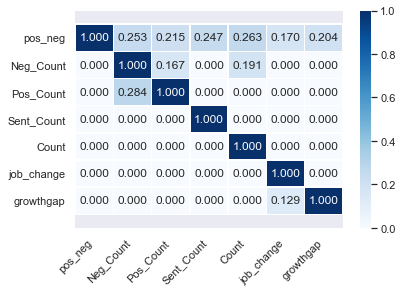

In [227]:
#pps matrix plot
powell_mkt_hm1 = powell_mkt.loc[:, [

"pos_neg",
"Neg_Count",
"Pos_Count",
"Sent_Count",
#"favorites",
"Count",
"job_change",
"growthgap"]]

ax = sns.heatmap(pps.matrix(powell_mkt_hm1), vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, fmt=".3f")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
;

# Save Figure
plt.savefig('./Images/powell_LCap_PPS_Matrix.png', figsize=(400,240))

# Show plot
plt.show()

Create lag values to add to features given that signals may adjust in lagged time.

In [228]:
powell_mkt['negcount1day'] = powell_mkt['Neg_Count'].shift(1)
powell_mkt['poscount1day'] = powell_mkt['Pos_Count'].shift(1)
powell_mkt['sentcount1day'] = powell_mkt['Sent_Count'].shift(1)
powell_mkt['econcount1day'] = powell_mkt['Count'].shift(1)
powell_mkt['job_change1day'] = powell_mkt['job_change'].shift(1)
powell_mkt['growthgap1day'] = powell_mkt['growthgap'].shift(1)
powell_mkt['change1day'] = powell_mkt['change'].shift(1)
powell_mkt['negcount2day'] = powell_mkt['Neg_Count'].shift(2)
powell_mkt['poscount2day'] = powell_mkt['Pos_Count'].shift(2)
powell_mkt['sentcount2day'] = powell_mkt['Sent_Count'].shift(2)
powell_mkt['econcount2day'] = powell_mkt['Count'].shift(2)
powell_mkt['job_change2day'] = powell_mkt['job_change'].shift(2)
powell_mkt['growthgap2day'] = powell_mkt['growthgap'].shift(2)
powell_mkt['change2day'] = powell_mkt['change'].shift(2)
powell_mkt['negcount3day'] = powell_mkt['Neg_Count'].shift(3)
powell_mkt['poscount3day'] = powell_mkt['Pos_Count'].shift(3)
powell_mkt['sentcount3day'] = powell_mkt['Sent_Count'].shift(3)
powell_mkt['econcount3day'] = powell_mkt['Count'].shift(3)
powell_mkt['job_change3day'] = powell_mkt['job_change'].shift(3)
powell_mkt['growthgap3day'] = powell_mkt['growthgap'].shift(3)
powell_mkt['change3day'] = powell_mkt['change'].shift(3)
powell_mkt['negcount4day'] = powell_mkt['Neg_Count'].shift(4)
powell_mkt['poscount4day'] = powell_mkt['Pos_Count'].shift(4)
powell_mkt['sentcount4day'] = powell_mkt['Sent_Count'].shift(4)
powell_mkt['econcount4day'] = powell_mkt['Count'].shift(4)
powell_mkt['job_change4day'] = powell_mkt['job_change'].shift(4)
powell_mkt['growthgap4day'] = powell_mkt['growthgap'].shift(4)
powell_mkt['change4day'] = powell_mkt['change'].shift(4)
powell_mkt['negcount5day'] = powell_mkt['Neg_Count'].shift(5)
powell_mkt['poscount5day'] = powell_mkt['Pos_Count'].shift(5)
powell_mkt['sentcount5day'] = powell_mkt['Sent_Count'].shift(5)
powell_mkt['econcount5day'] = powell_mkt['Count'].shift(5)
powell_mkt['job_change5day'] = powell_mkt['job_change'].shift(5)
powell_mkt['growthgap5day'] = powell_mkt['growthgap'].shift(5)
powell_mkt['change5day'] = powell_mkt['change'].shift(5)
powell_mkt['negcount6day'] = powell_mkt['Neg_Count'].shift(6)
powell_mkt['poscount6day'] = powell_mkt['Pos_Count'].shift(6)
powell_mkt['sentcount6day'] = powell_mkt['Sent_Count'].shift(6)
powell_mkt['econcount6day'] = powell_mkt['Count'].shift(6)
powell_mkt['job_change6day'] = powell_mkt['job_change'].shift(6)
powell_mkt['growthgap6day'] = powell_mkt['growthgap'].shift(6)
powell_mkt['change6day'] = powell_mkt['change'].shift(6)
powell_mkt['negcount7day'] = powell_mkt['Neg_Count'].shift(7)
powell_mkt['poscount7day'] = powell_mkt['Pos_Count'].shift(7)
powell_mkt['sentcount7day'] = powell_mkt['Sent_Count'].shift(7)
powell_mkt['econcount7day'] = powell_mkt['Count'].shift(7)
powell_mkt['job_change7day'] = powell_mkt['job_change'].shift(7)
powell_mkt['growthgap7day'] = powell_mkt['growthgap'].shift(7)
powell_mkt['change7day'] = powell_mkt['change'].shift(7)
powell_mkt['negcount8day'] = powell_mkt['Neg_Count'].shift(8)
powell_mkt['poscount8day'] = powell_mkt['Pos_Count'].shift(8)
powell_mkt['sentcount8day'] = powell_mkt['Sent_Count'].shift(8)
powell_mkt['econcount8day'] = powell_mkt['Count'].shift(8)
powell_mkt['job_change8day'] = powell_mkt['job_change'].shift(8)
powell_mkt['growthgap8day'] = powell_mkt['growthgap'].shift(8)
powell_mkt['change8day'] = powell_mkt['change'].shift(8)
powell_mkt['negcount9day'] = powell_mkt['Neg_Count'].shift(9)
powell_mkt['poscount9day'] = powell_mkt['Pos_Count'].shift(9)
powell_mkt['sentcount9day'] = powell_mkt['Sent_Count'].shift(9)
powell_mkt['econcount9day'] = powell_mkt['Count'].shift(9)
powell_mkt['job_change9day'] = powell_mkt['job_change'].shift(9)
powell_mkt['growthgap9day'] = powell_mkt['growthgap'].shift(9)
powell_mkt['change9day'] = powell_mkt['change'].shift(9)
powell_mkt['negcount10day'] = powell_mkt['Neg_Count'].shift(10)
powell_mkt['poscount10day'] = powell_mkt['Pos_Count'].shift(10)
powell_mkt['sentcount10day'] = powell_mkt['Sent_Count'].shift(10)
powell_mkt['econcount10day'] = powell_mkt['Count'].shift(10)
powell_mkt['job_change10day'] = powell_mkt['job_change'].shift(10)
powell_mkt['growthgap10day'] = powell_mkt['growthgap'].shift(10)
powell_mkt['change10day'] = powell_mkt['change'].shift(10)
powell_mkt['negcount11day'] = powell_mkt['Neg_Count'].shift(11)
powell_mkt['poscount11day'] = powell_mkt['Pos_Count'].shift(11)
powell_mkt['sentcount11day'] = powell_mkt['Sent_Count'].shift(11)
powell_mkt['econcount11day'] = powell_mkt['Count'].shift(11)
powell_mkt['job_change11day'] = powell_mkt['job_change'].shift(11)
powell_mkt['growthgap11day'] = powell_mkt['growthgap'].shift(11)
powell_mkt['change11day'] = powell_mkt['change'].shift(11)
powell_mkt['negcount12day'] = powell_mkt['Neg_Count'].shift(12)
powell_mkt['poscount12day'] = powell_mkt['Pos_Count'].shift(12)
powell_mkt['sentcount12day'] = powell_mkt['Sent_Count'].shift(12)
powell_mkt['econcount12day'] = powell_mkt['Count'].shift(12)
powell_mkt['job_change12day'] = powell_mkt['job_change'].shift(12)
powell_mkt['growthgap12day'] = powell_mkt['growthgap'].shift(12)
powell_mkt['change12day'] = powell_mkt['change'].shift(12)
powell_mkt['negcount13day'] = powell_mkt['Neg_Count'].shift(13)
powell_mkt['poscount13day'] = powell_mkt['Pos_Count'].shift(13)
powell_mkt['sentcount13day'] = powell_mkt['Sent_Count'].shift(13)
powell_mkt['econcount13day'] = powell_mkt['Count'].shift(13)
powell_mkt['job_change13day'] = powell_mkt['job_change'].shift(13)
powell_mkt['growthgap13day'] = powell_mkt['growthgap'].shift(13)
powell_mkt['change13day'] = powell_mkt['change'].shift(13)
powell_mkt['negcount14day'] = powell_mkt['Neg_Count'].shift(14)
powell_mkt['poscount14day'] = powell_mkt['Pos_Count'].shift(14)
powell_mkt['sentcount14day'] = powell_mkt['Sent_Count'].shift(14)
powell_mkt['job_change14day'] = powell_mkt['job_change'].shift(14)
powell_mkt['growthgap14day'] = powell_mkt['growthgap'].shift(14)
powell_mkt['econcount14day'] = powell_mkt['change'].shift(14)
powell_mkt['change14day'] = powell_mkt['change'].shift(14)
powell_mkt['negcount15day'] = powell_mkt['Neg_Count'].shift(15)
powell_mkt['poscount15day'] = powell_mkt['Pos_Count'].shift(15)
powell_mkt['sentcount15day'] = powell_mkt['Sent_Count'].shift(15)
powell_mkt['econcount15day'] = powell_mkt['Count'].shift(15)
powell_mkt['job_change15day'] = powell_mkt['job_change'].shift(15)
powell_mkt['growthgap15day'] = powell_mkt['growthgap'].shift(15)
powell_mkt['change15day'] = powell_mkt['change'].shift(15)
powell_mkt.head(1)

,date,change,Date,Neg_Count,Pos_Count,Sent_Count,Count,pos_neg,pos,neg,...,growthgap14day,econcount14day,change14day,negcount15day,poscount15day,sentcount15day,econcount15day,job_change15day,growthgap15day,change15day
0,2016-02-26,-0.007529,2016-02-26,20,15,-5,3,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [318]:
powell_mkt.to_csv('./Data/powell_lmkt.csv', index=False)

In [230]:
for x in powell_mkt.columns:
    print(x)

date
change
Date
Neg_Count
Pos_Count
Sent_Count
Count
pos_neg
pos
neg
flat
growthgap
job_change
negcount1day
poscount1day
sentcount1day
econcount1day
job_change1day
growthgap1day
change1day
negcount2day
poscount2day
sentcount2day
econcount2day
job_change2day
growthgap2day
change2day
negcount3day
poscount3day
sentcount3day
econcount3day
job_change3day
growthgap3day
change3day
negcount4day
poscount4day
sentcount4day
econcount4day
job_change4day
growthgap4day
change4day
negcount5day
poscount5day
sentcount5day
econcount5day
job_change5day
growthgap5day
change5day
negcount6day
poscount6day
sentcount6day
econcount6day
job_change6day
growthgap6day
change6day
negcount7day
poscount7day
sentcount7day
econcount7day
job_change7day
growthgap7day
change7day
negcount8day
poscount8day
sentcount8day
econcount8day
job_change8day
growthgap8day
change8day
negcount9day
poscount9day
sentcount9day
econcount9day
job_change9day
growthgap9day
change9day
negcount10day
poscount10day
sentcount10day
econcount10day


Machine Learning Models: RandomForesRegression & Ridge for the model with % change of prices for SPY, MDY and IJR as labels; RandomClassifier and LogisticRegressor for the models with labels as classifiers of price change directions -- up or down. The RandomFlorest models also oberve feature importance and decision trees. 

In [231]:
powell_mkt.dropna(inplace=True)
powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 11:13]] #1 %Change (y_3)
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 11:13]] #2 Classification Change (y_1)
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7]] #3 y_1 Neg_Count, Pos_Count, Count

powell_lmkt_x.set_index("date", inplace=True)
powell_lmkt_y1 = powell_mkt['pos_neg']
powell_lmkt_y2 = powell_mkt[['pos','neg','flat']]
powell_lmkt_y3 = powell_mkt[['change']]
powell_lmkt_x.head(1)
#powell_lmkt_x.to_csv('./Data/powell_lmkt_x.csv', index=True)
#powell_lmkt_y1.to_csv('./Data/powell_lmkt_y1.csv', index=False)

,Neg_Count,Pos_Count,Count,growthgap,job_change
date,,,,,
2017-06-26,26,33,2,1.1,141.0


In [232]:
X_train, X_test,y_train,y_test = train_test_split(powell_lmkt_x, powell_lmkt_y3, test_size = 0.33,random_state=42)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#1 %Change

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

-0.5018246835893052
-0.1093561976849664


In [233]:
powell_mkt.dropna(inplace=True)
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 11:13]] #1 %Change (y_3)
powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 11:13]] #2 Classification Change (y_1)
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7]] #3 y_1, Pos_Count, Neg_Count, Count

powell_lmkt_x.set_index("date", inplace=True)
powell_lmkt_y1 = powell_mkt['pos_neg']
powell_lmkt_y2 = powell_mkt[['pos','neg','flat']]
powell_lmkt_y3 = powell_mkt[['change']]
#powell_lmkt_x.head(1)
#powell_lmkt_x.to_csv('./Data/powell_lmkt_x.csv', index=True)
#powell_lmkt_y1.to_csv('./Data/powell_lmkt_y1.csv', index=False)

In [234]:
X_train, X_test,y_train,y_test = train_test_split(powell_lmkt_x, powell_lmkt_y1, test_size = 0.33,random_state=42)
from sklearn.ensemble import RandomForestClassifier

regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#2 Pos_Count, Neg_Count, Count, job_change, growthgap




ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

0.5
-0.14468731713005023


In [235]:
powell_mkt.dropna(inplace=True)
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 11:13]] #1 %Change
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 11:13]] #2 Pos_Count, Neg_Count, Count, job_change, growthgap
powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7]] #3 Pos_Count, Neg_Count, Count

powell_lmkt_x.set_index("date", inplace=True)
powell_lmkt_y1 = powell_mkt['pos_neg']
powell_lmkt_y2 = powell_mkt[['pos','neg','flat']]
powell_lmkt_y3 = powell_mkt[['change']]
powell_lmkt_x.head(1)
#powell_lmkt_x.to_csv('./Data/powell_lmkt_x.csv', index=True)
#powell_lmkt_y1.to_csv('./Data/powell_lmkt_y1.csv', index=False)

,Neg_Count,Pos_Count,Count
date,,,
2017-06-26,26,33,2


In [236]:
X_train, X_test,y_train,y_test = train_test_split(powell_lmkt_x, powell_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#3 Pos_Count, Neg_Count, Count

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

0.6666666666666666
-0.08793750936453315


In [243]:
powell_mkt.dropna(inplace=True)
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 11:13]] #1 %Change
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 11:13]] #2 Pos_Count, Neg_Count, Count, job_change, growthgap
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7]] #3 Pos_Count, Neg_Count, Count
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 5:6, 6:7]] #4 Sent_Count, Count
powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 5:6]] #4.1 Sent_Count

powell_lmkt_x.set_index("date", inplace=True)
powell_lmkt_y1 = powell_mkt['pos_neg']
powell_lmkt_y2 = powell_mkt[['pos','neg','flat']]
powell_lmkt_y3 = powell_mkt[['change']]
powell_lmkt_x.head(1)
#powell_lmkt_x.to_csv('./Data/powell_lmkt_x.csv', index=True)
#powell_lmkt_y1.to_csv('./Data/powell_lmkt_y1.csv', index=False)

,Sent_Count
date,
2017-06-26,7


In [244]:
X_train, X_test,y_train,y_test = train_test_split(powell_lmkt_x, powell_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))


#4.1 Sent_Count

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

0.4166666666666667
-0.08802973895135024


In [242]:
X_train, X_test,y_train,y_test = train_test_split(powell_lmkt_x, powell_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#4 Sent_Count, Count

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

-0.4894509259259261
-0.08802973895135024


In [249]:
powell_mkt.dropna(inplace=True)
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 13:15, 19:20]] #5.1 with 1 lag
powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 13:15, 16:17, 19:20]] #5 with 1 lag
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 13:15, 16:17, 19:22, 23:24, 26:29, 30:31,33:36, 37:38, 40:43, 44:45, 47:50, 51:52, 54:57, 58:59, 61:62]] #6 with 7 lags
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 13:15, 16:17, 19:22, 23:24, 26:29, 30:31,33:36, 37:38, 40:43, 44:45, 47:50, 51:52, 54:57, 58:59, 61:64, 65:66, 68:71, 72:73, 75:78, 79:80, 82:85, 86:87, 89:92, 93:94, 96:99, 100:101, 103:106, 107:108, 110-113, 114:115, 117:118]] #7 with 15 lags

powell_lmkt_x.set_index("date", inplace=True)
powell_lmkt_y1 = powell_mkt['pos_neg']
powell_lmkt_y2 = powell_mkt[['pos','neg','flat']]
powell_lmkt_y3 = powell_mkt[['change']]
powell_lmkt_x.head(1)
#powell_lmkt_x.to_csv('./Data/powell_lmkt_x.csv', index=True)
#powell_lmkt_y1.to_csv('./Data/powell_lmkt_y1.csv', index=False)

,Neg_Count,Pos_Count,Count,negcount1day,poscount1day,econcount1day,change1day
date,,,,,,,
2017-06-26,26,33,2,65.0,41.0,10.0,0.000906


In [250]:
X_train, X_test,y_train,y_test = train_test_split(powell_lmkt_x, powell_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))

#5 with 1 lag

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

sorted(zip(regr.feature_importances_, powell_mkt.iloc[:, np.r_[3:5, 6:7, 13:15, 16:17, 19:20]]), reverse=True)

0.5833333333333334
0.05270388450256058


[(0.33500717716626804, 'poscount1day'),
 (0.19209325737615215, 'negcount1day'),
 (0.12449178623520726, 'change1day'),
 (0.11167455187909736, 'Count'),
 (0.11126768942558415, 'Neg_Count'),
 (0.06678588423803736, 'econcount1day'),
 (0.058679653679653686, 'Pos_Count')]

In [248]:
X_train, X_test,y_train,y_test = train_test_split(powell_lmkt_x, powell_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))


#6 with 7 lags

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

sorted(zip(regr.feature_importances_, powell_mkt.iloc[:, np.r_[3:5, 6:7, 13:15, 16:17, 19:22, 23:24, 26:29, 30:31,33:36, 37:38, 40:43, 44:45, 47:50, 51:52, 54:57, 58:59, 61:62]]), reverse=True)

0.5
-3.041330451239876


[(0.15309283309283309, 'poscount1day'),
 (0.0915292042743023, 'poscount7day'),
 (0.07864740087954372, 'negcount1day'),
 (0.06584620716973659, 'poscount6day'),
 (0.059522144522144514, 'negcount5day'),
 (0.059400800918658056, 'Pos_Count'),
 (0.05679012345679011, 'change6day'),
 (0.05394383394383394, 'change2day'),
 (0.05111111111111111, 'negcount4day'),
 (0.04971440596440596, 'negcount6day'),
 (0.04888888888888889, 'Neg_Count'),
 (0.037986550486550495, 'change3day'),
 (0.03484848484848485, 'econcount7day'),
 (0.03208698708698709, 'poscount4day'),
 (0.027072464572464584, 'Count'),
 (0.025462962962962958, 'negcount7day'),
 (0.02019425019425019, 'change4day'),
 (0.01932773109243698, 'poscount3day'),
 (0.015726495726495725, 'econcount3day'),
 (0.013939393939393937, 'poscount5day'),
 (0.004867724867724873, 'econcount2day'),
 (0.0, 'poscount2day'),
 (0.0, 'negcount3day'),
 (0.0, 'negcount2day'),
 (0.0, 'econcount6day'),
 (0.0, 'econcount5day'),
 (0.0, 'econcount4day'),
 (0.0, 'econcount1day'),

In [246]:
X_train, X_test,y_train,y_test = train_test_split(powell_lmkt_x, powell_lmkt_y1, test_size = 0.33,random_state=42)
regr = RandomForestClassifier()
regr.fit(X_train,y_train)
print(regr.score(X_test, y_test))


#7 with 15 lags

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))
# regr.predict_proba(X_test)

sorted(zip(regr.feature_importances_, powell_mkt.iloc[:, np.r_[3:5, 6:7, 13:15, 16:17, 19:22, 23:24, 26:29, 30:31,33:36, 37:38, 40:43, 44:45, 47:50, 51:52, 54:57, 58:59, 61:64, 65:66, 68:71, 72:73, 75:78, 79:80, 82:85, 86:87, 89:92, 93:94, 96:99, 100:101, 103:106, 107:108, 110-113, 114:115, 117:118]]), reverse=True)

0.4166666666666667
-0.04535211373488468


[(0.08612677763413054, 'econcount1day'),
 (0.08083333333333334, 'poscount11day'),
 (0.07051282051282051, 'change6day'),
 (0.06900335775335778, 'negcount12day'),
 (0.052083333333333336, 'Neg_Count'),
 (0.051624902874902866, 'negcount6day'),
 (0.04888888888888889, 'change10day'),
 (0.04320987654320989, 'negcount11day'),
 (0.04265216265216265, 'change2day'),
 (0.03975308641975307, 'change5day'),
 (0.038614163614163616, 'negcount14day'),
 (0.03685897435897435, 'econcount7day'),
 (0.036111111111111115, 'negcount13day'),
 (0.036111111111111115, 'econcount6day'),
 (0.03365384615384616, 'negcount1day'),
 (0.03317307692307692, 'change1day'),
 (0.029487179487179487, 'econcount10day'),
 (0.029206349206349198, 'econcount2day'),
 (0.025274725274725275, 'poscount2day'),
 (0.02464285714285714, 'Pos_Count'),
 (0.02319327731092437, 'job_change14day'),
 (0.018482142857142857, 'poscount8day'),
 (0.017037037037037038, 'change8day'),
 (0.016428571428571435, 'econcount4day'),
 (0.013690476190476189, 'negcou

In [319]:
powell_mkt.dropna(inplace=True)
powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 13:15, 19:20]] #5.1 with 1 lag
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 13:15, 16:17, 19:20]] #5 with 1 lag
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 13:15, 16:17, 19:22, 23:24, 26:29, 30:31,33:36, 37:38, 40:43, 44:45, 47:50, 51:52, 54:57, 58:59, 61:62]] #6 with 7 lags
#powell_lmkt_x = powell_mkt.iloc[:, np.r_[0, 3:5, 6:7, 13:15, 16:17, 19:22, 23:24, 26:29, 30:31,33:36, 37:38, 40:43, 44:45, 47:50, 51:52, 54:57, 58:59, 61:64, 65:66, 68:71, 72:73, 75:78, 79:80, 82:85, 86:87, 89:92, 93:94, 96:99, 100:101, 103:106, 107:108, 110-113, 114:115, 117:118]] #7 with 15 lags

powell_lmkt_x.set_index("date", inplace=True)
powell_lmkt_y1 = powell_mkt['pos_neg']
powell_lmkt_y2 = powell_mkt[['pos','neg','flat']]
powell_lmkt_y3 = powell_mkt[['change']]

powell_lmkt_x.to_csv('./Data/powell_lmkt_x.csv', index=True)
powell_lmkt_y1.to_csv('./Data/powell_lmkt_y1.csv', index=False)

powell_lmkt_x.head(1)

,Neg_Count,Pos_Count,Count,negcount1day,poscount1day,change1day
date,,,,,,
2017-06-26,26,33,2,65.0,41.0,0.000906


In [313]:
X_train, X_test,y_train,y_test = train_test_split(powell_lmkt_x, powell_lmkt_y1, test_size = 0.33,random_state=42)
regrfn = RandomForestClassifier()
regrfn.fit(X_train,y_train)
print(regrfn.score(X_test, y_test))

#5.1 with 1 lag (with no lag for Count)

ridge = Ridge()
ridge.fit(X_train,y_train)
print(ridge.score(X_test, y_test))

print(regrfn.predict_proba(X_test))

sorted(zip(regrfn.feature_importances_, powell_mkt.iloc[:, np.r_[3:5, 6:7, 13:15, 19:20]]), reverse=True)

0.75
-0.0033859932061082176
[[0.8 0.2]
 [0.9 0.1]
 [0.5 0.5]
 [0.3 0.7]
 [0.8 0.2]
 [0.8 0.2]
 [0.3 0.7]
 [0.7 0.3]
 [0.2 0.8]
 [0.5 0.5]
 [0.9 0.1]
 [0.6 0.4]]


[(0.3643199035812673, 'poscount1day'),
 (0.1815151515151515, 'Neg_Count'),
 (0.17583995780923853, 'change1day'),
 (0.11799709468852829, 'negcount1day'),
 (0.0851600419782238, 'Pos_Count'),
 (0.0751678504275907, 'Count')]

In [315]:
# Calculate classification report
from sklearn.metrics import classification_report
y_pred = regrfn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.50      0.67         6

    accuracy                           0.75        12
   macro avg       0.83      0.75      0.73        12
weighted avg       0.83      0.75      0.73        12



In [316]:
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
confusion_matrix(y_test, y_pred)

array([[6, 0],
       [3, 3]], dtype=int64)

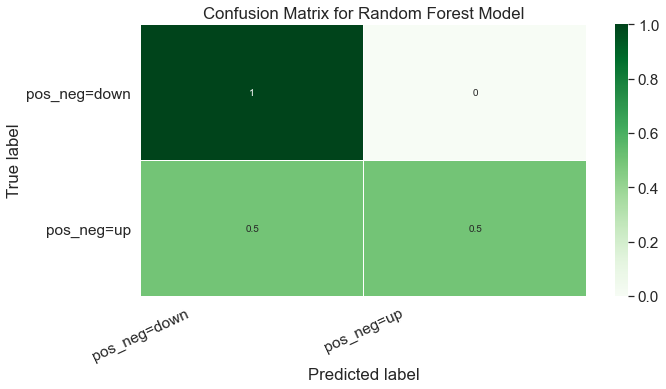

In [320]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
# Build the plot
plt.figure(figsize=(10,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
# Add labels to the plot
class_names = ['pos_neg=down', 'pos_neg=up']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.savefig('./Images/powell_LCap_rf_y_pred_confusion_matrix.png',bbox_inches="tight")
plt.show()

In [308]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.75

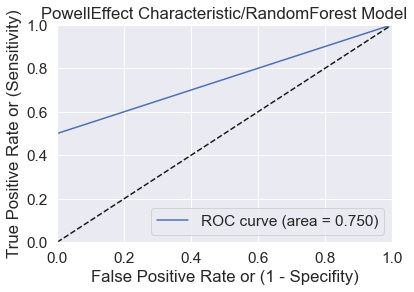

In [309]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('PowellEffect Characteristic/RandomForest Model')
plt.legend(loc="lower right")
plt.savefig('./Images/powell_LCap_rf_y_pred.png',bbox_inches="tight")

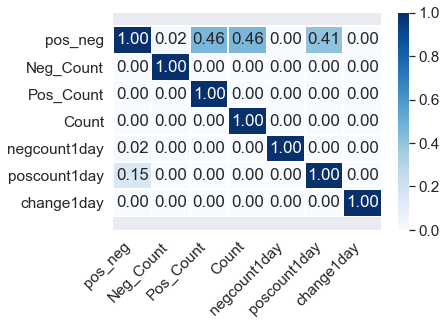

In [310]:
#pps matrix plot
powell_mkt_hm1 = powell_mkt.loc[:, [
    
"pos_neg",
"Neg_Count",
"Pos_Count",
"Count",
"negcount1day",
"poscount1day",
"change1day"

]]

ax = sns.heatmap(pps.matrix(powell_mkt_hm1), vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, fmt=".2f")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
;
# plt.tight_layout()

# Save Figure
plt.savefig('./Images/powell_LCapM_PPS_Matrix.png',bbox_inches="tight")

# Show plot
plt.show()

In [317]:
filename = 'powell_lgcap_model.sav'
pickle.dump(regrfn, open(filename, 'wb'))